# Case 2 notebook VERSION 2

This model was based on the version 1 model, which had a surprising accuracy but other test metrics left room for improvement. Creating a new network with a small number of data instances, as in version 1, will eventually cause model overfitting and prediction accuracy is far from perfect. There are several ways to combat the relative lack of original data. In this notebook, mainly two major ways are introduced: *data augmentation* and using a *pretrained network*.

In [2]:
%pylab inline
import pandas as pd 
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.metrics import Accuracy,FalseNegatives, FalsePositives
import os
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

Populating the interactive namespace from numpy and matplotlib


C:\Users\I\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\I\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\I\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\I\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or 

### Pretrained network
Another way to improve the neural network, is to use a pretrained network. The used network must be of similar type: i.e. trained to identify similar data. This notebook uses a popular image data analysis network called VGG16, which is available in the Tensorflow library. VGG16 is a convolutional neural network model designed by K. Simonyan and A. Zisserman (2014) from the University of Oxford in their paper “Very Deep Convolutional Networks for Large-Scale Image Recognition”. VGG16 has been trained with ImageNet, which in turn is an image database containing some 14 million images belonging to 1000 classes. 

This network is used as a base, and given the pneumonia data as additional training. After importing, most of the layers of the pretrained network are *frozen*. This means those layers do take the pneumonia data, but during training the weights for those layers remain unchanged. Final layers of of the network are *unfrozen*: these layers DO shift their weights in additional training. In this way, the base VGG16 network has been pretrained to handle image data well, but then given extra expertise on the topic of chest xray images and their classification into healthy or pneumonia class.

An important note to take into account, is the model learning rate. Model learning rate depicts how strongly the network is "allowed" to modify feature weights. Higher learning rate means that the network can "guess" larger deviations from earlier results. Compared to version 1 rate of 2e-5 (2 * 10 to the power of -5), in this model the rate is lowered to 1e-5 (1 * 10 to the power of -5). This is to avoid large variances in weights each time data is put through the unfrozen fifth layer. 

In [3]:
# VGG16 model is saved into a variable
conv_base = VGG16(weights='imagenet',
include_top=False,
input_shape=(150, 150, 3))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [4]:
# Print a description of the preloaded VGG16 model
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [7]:
# Load data from folders
base_dir = r'C:\Users\I\Desktop\Neural networks\Neural network data\Case2'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [8]:
# The fifth convolutional layer is unfrozen, which means the backpropagation function is able to change the weights on this layer.
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [9]:
# Two new convolutional layers are created to the end of the VGG16 base network. The first new layer contains 256 nodes, and the final layer only one node.
# The final layer uses a sigmoid function for output, so that the final result binary 0 or 1. This result is the prediction value for each image.
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

## Data augmentation: 
Data augmentation is a varied number of methods which are used to reduce overfitting, especially in cases of small datasets. With different ways of data augmentation, every item of image data can be multiplied by contorting, rotating, shifting etc. the original images. Thus, using one image as a base, several images can be created and used for training. In this way, the specific details of a single image are "blurred" in a sense, as the network must now focus on more general features to find significant differences. 

Specifically, rotation is an important data augmentation point with this exact dataset, as xray images may be naturally tilted a few degrees because people do not stand perfectly vertical and still. Perhaps somewhat unintuitively, rotating all pictures a certain degree to a random direction, gives the network a chance to disregard this natural occurring tilt. It must be noted that *only* the training set is augmented, as validation and test sets are not used for training.

In [10]:
#Rescale Images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    #horizontal_flip=True,
    fill_mode='nearest')

#Rescale Images
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    #shuffle=False,
    class_mode='binary')

all_metrics = ['acc', FalseNegatives(), FalsePositives()] 
#For frozen conv_base
#model.compile(loss='binary_crossentropy',
# #           optimizer=optimizers.RMSprop(lr=2e-5),
#            metrics=all_metrics)#metrics=['acc'])
#Un frozen conv_base
model.compile(loss='binary_crossentropy',
            optimizer=optimizers.RMSprop(lr=1e-5),
            metrics=all_metrics)#metrics=['acc'])

Found 3512 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
history = model.fit_generator(
            train_generator,
            #steps_per_epoch=100,
            epochs=100,
            validation_data=validation_generator)#,
            #validation_steps=50)

Epoch 1/100
110/110 [==============================] - 85s 773ms/step - loss: 0.2875 - acc: 0.8750 - false_negatives: 101.0000 - false_positives: 338.0000 - val_loss: 0.2409 - val_acc: 0.9010 - val_false_negatives: 101.0000 - val_false_positives: 15.0000
Epoch 2/100
110/110 [==============================] - 73s 659ms/step - loss: 0.1782 - acc: 0.9314 - false_negatives: 114.0000 - false_positives: 127.0000 - val_loss: 0.1927 - val_acc: 0.9283 - val_false_negatives: 73.0000 - val_false_positives: 11.0000
Epoch 3/100
110/110 [==============================] - 72s 658ms/step - loss: 0.1544 - acc: 0.9428 - false_negatives: 93.0000 - false_positives: 108.0000 - val_loss: 0.2070 - val_acc: 0.9172 - val_false_negatives: 86.0000 - val_false_positives: 11.0000
Epoch 4/100
110/110 [==============================] - 72s 657ms/step - loss: 0.1412 - acc: 0.9462 - false_negatives: 87.0000 - false_positives: 102.0000 - val_loss: 0.1638 - val_acc: 0.9360 - val_false_negatives: 63.0000 - val_false_posi

110/110 [==============================] - 72s 657ms/step - loss: 0.0284 - acc: 0.9906 - false_negatives: 17.0000 - false_positives: 16.0000 - val_loss: 0.1988 - val_acc: 0.9454 - val_false_negatives: 53.0000 - val_false_positives: 11.0000
Epoch 66/100
110/110 [==============================] - 72s 658ms/step - loss: 0.0196 - acc: 0.9932 - false_negatives: 9.0000 - false_positives: 15.0000 - val_loss: 0.4279 - val_acc: 0.9061 - val_false_negatives: 107.0000 - val_false_positives: 3.0000
Epoch 67/100
110/110 [==============================] - 73s 660ms/step - loss: 0.0192 - acc: 0.9935 - false_negatives: 9.0000 - false_positives: 14.0000 - val_loss: 0.1975 - val_acc: 0.9539 - val_false_negatives: 43.0000 - val_false_positives: 11.0000
Epoch 68/100
110/110 [==============================] - 73s 659ms/step - loss: 0.0183 - acc: 0.9929 - false_negatives: 12.0000 - false_positives: 13.0000 - val_loss: 0.1595 - val_acc: 0.9625 - val_false_negatives: 32.0000 - val_false_positives: 12.0000
Epo

# Training and validation results
First, accurate graphs for test accuracy, loss, false positives and false negatives are displayed. Discussion of results proceeds after the graphs.

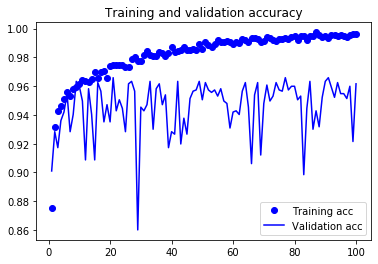

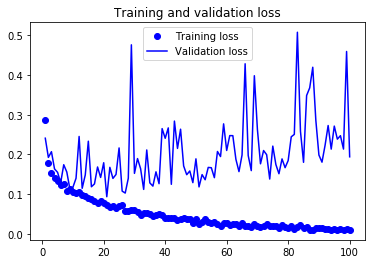

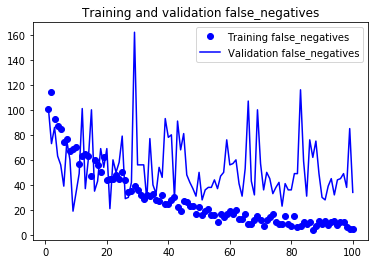

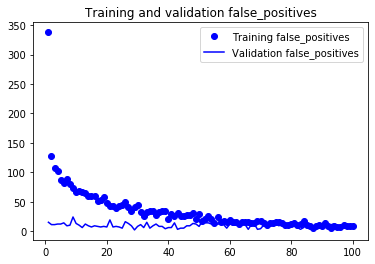

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
fn = history.history['false_negatives']
fn_v = history.history['val_false_negatives']
fp = history.history['false_positives']
fp_n = history.history['val_false_positives']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()
plt.plot(epochs, fn, 'bo', label='Training false_negatives')
plt.plot(epochs, fn_v, 'b', label='Validation false_negatives')
plt.title('Training and validation false_negatives')
plt.legend()
plt.figure()
plt.plot(epochs, fp, 'bo', label='Training false_positives')
plt.plot(epochs, fp_n, 'b', label='Validation false_positives')
plt.title('Training and validation false_positives')
plt.legend()
plt.show()

The curves are smoothened so that the visual changes and trends (overfitting) are easier to spot when every little jump in data is not so prominently visible. 

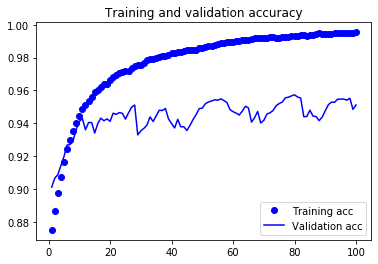

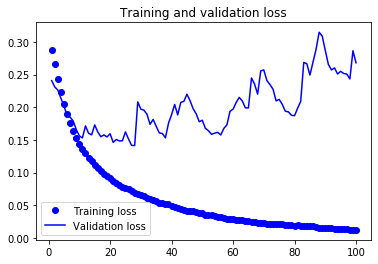

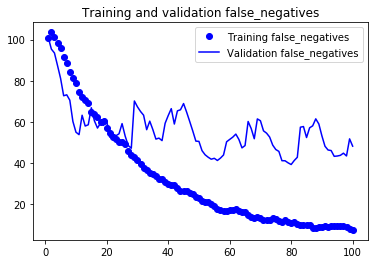

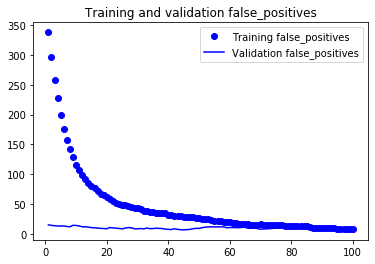

In [13]:
# Plot smoother curves
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
#smooth_curve(loss)
#Smoothed validation loss
plt.plot(epochs, smooth_curve(acc), 'bo', label='Training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, smooth_curve(loss), 'bo', label='Training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()
plt.plot(epochs, smooth_curve(fn), 'bo', label='Training false_negatives')
plt.plot(epochs, smooth_curve(fn_v), 'b', label='Validation false_negatives')
plt.title('Training and validation false_negatives')
plt.legend()
plt.figure()
plt.plot(epochs, smooth_curve(fp), 'bo', label='Training false_positives')
plt.plot(epochs, smooth_curve(fp_n), 'b', label='Validation false_positives')
plt.title('Training and validation false_positives')
plt.legend()
plt.show()

## Discussion
Accuracy is improved from the earlier model (ACC 96%) to ACC 97%. The accuracy rises quickly to its peak of around 94%, but changes very little after.

Loss starts ok, but begins to overfit around epoch 25: the jittery upslope is clear from the graph. For a good validation result the validation loss should keep going lower and lower.

With false negatives, it would seem that the sweet spot would also be somewhere near 30 epochs, where the training curve meets validation curve. The validation curve may have a gentle downward trend.

Validation false positive results are awkward: immediately from the start the false positives remain constant, with no observable result from training. The team theorized this can result from many "substandard" xray images that may occur in the sets.

All in all, it seems that to concretely visualize the upward/downward trends, more epochs could be in order. This would not benefit the model, but would help in network ability assessment. Unfortunately, the team could not afford more hours of model building because of scheduling.

# Testing the model
Finally, the test set is run through the network. Hopefully, the confusion matrix has improved in this more accurate model.

In [18]:
#Evaluate the data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    shuffle=False,
    class_mode='binary')
test_loss, test_acc, test_falseNegatives, test_falsePositives = model.evaluate_generator(test_generator)#test_generator
print('test acc:', test_acc)
print('test loss:', test_loss)
print('test false negatives',test_falseNegatives)
print('test false positives',test_falsePositives)
model.save('Case 2.V2.h5')

Found 1170 images belonging to 2 classes.
test acc: 0.9692308
test loss: 0.17398509493798614
test false negatives 31.0
test false positives 5.0


# Prediction / true values graph

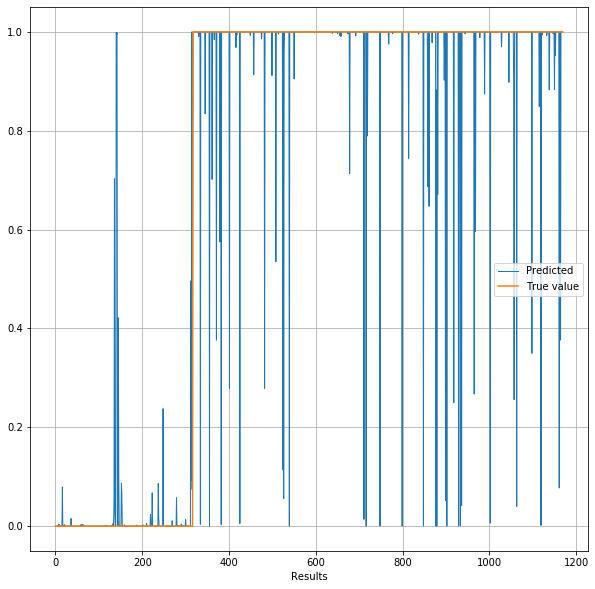

In [30]:
fig = plt.figure(figsize=(10, 10))
labels = test_generator.classes
prediction = model.predict_generator(test_generator).flatten()#, steps=50
plot(prediction, label='Predicted', linewidth=1)
plot(labels, label='True value')
legend()
xlabel('Results')
grid()

Compared to the Prediction/True value graph in V1, the V2 graph looks better. Predicted and true values are less frequently apart from each other and the graph looks overall more reable than graph in V1. Still there is quite a few pictures that where misidentified either as 1s when they are actually 0s or as 0s when they in fact are 1s.

In [38]:
# Print confusion matrix and classification raport

cf_mx = confusion_matrix(labels, prediction > 0.25)
print("Confusion matrix: ")
print(cf_mx)
tn, fp, fn, tp = confusion_matrix(labels, prediction  > 0.25).ravel()
sensitivity = tp/(fn+tp)
specificity = tn/(fp+tn)
print("Sensitivity",sensitivity)
print("Specificity",specificity)
cl_rt = classification_report(labels, prediction > 0.25, target_names = ['Normal (0)', 'Pneumonia (1)'])
print(cl_rt)
#Sensitivity = TP / FN+TP
#Specificity = TN/FP+TN

# Confusion matrix:
# TN FP
# FN TP
# FN False Negative
# FP False Positive
# TN True Negative
# TP True Positive

# Precision = TP / Number of actually positive patients
# Recall = Sensitivity = TP / Number of model predicted positive patients

Confusion matrix: 
[[309   8]
 [ 23 830]]
Sensitivity 0.9730363423212193
Specificity 0.9747634069400631
               precision    recall  f1-score   support

   Normal (0)       0.93      0.97      0.95       317
Pneumonia (1)       0.99      0.97      0.98       853

     accuracy                           0.97      1170
    macro avg       0.96      0.97      0.97      1170
 weighted avg       0.97      0.97      0.97      1170



## Test results
Test set accuracy is a phenomenal 97%, with sensitivity and specificity being also very high. With this model, only 3 % of sick or healthy patients would be wrongly diagnosed. 

It should be noted that compared to the OK version 1 model, specificity increased 7% and recall of healthy patients increased 7%.

It is clear that data augmentation methods and VGG16 premade network improved performance from "OK" results to good results.

There still remains the worry of increasing loss in validation after epoch 25. In the third notebook, the results of lowering the number of epochs are researched.